## Import Libraries

Import all necessary libraries for data manipulation, visualization, and modeling.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

### Read the CSV File

Load the insurance dataset and display its shape and first few rows.

In [29]:
import pandas as pd

# Load your dataset
df = pd.read_csv(r"C:\Users\Student\Downloads\JoyP\Medical-Cost-Prediction-Smoking-Risk-Classification\Data\insurance.csv")  # adjust path/filename as needed

# Show columns and types
print(df.shape)
df.head()


(228711, 42)


,ID,ID_policy,ID_insured,period,date_effect_insured,date_lapse_insured,date_effect_policy,date_lapse_policy,year_effect_insured,year_lapse_insured,...,C_H,C_GI,C_II,C_IE_P,C_IE_S,C_IE_T,C_GE_P,C_GE_S,C_GE_T,C_C
0,1_1,1,1,2017,6/15/1993,12/20/2017,6/15/1993,NaN,1993,2017.0,...,H1,99.0,85.0,18.0,52.0,59.0,4.0,14.0,96.0,C6
1,1_2,1,2,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,H1,99.0,85.0,18.0,52.0,59.0,4.0,14.0,96.0,C6
2,2_1,2,1,2017,6/16/1993,NaN,6/16/1993,NaN,1993,NaN,...,H6,100.0,94.0,26.0,11.0,85.0,7.0,1.0,100.0,C6
3,3_3,3,3,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3_5,3,5,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,H6,99.0,81.0,32.0,34.0,69.0,9.0,4.0,98.0,C6


### Data Overview

Check the data types, summary statistics, and missing values.

In [47]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228711 entries, 0 to 228710
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   228711 non-null  float64
 1   gender                228711 non-null  int64  
 2   premium               228711 non-null  float64
 3   n_medical_services    228711 non-null  float64
 4   distribution_channel  228711 non-null  int64  
 5   type_policy           228711 non-null  int64  
 6   type_product          228711 non-null  int64  
 7   cost_claims_year      228711 non-null  float64
 8   age_group             228711 non-null  int64  
 9   premium_per_service   228711 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 17.4 MB


,age,gender,premium,n_medical_services,distribution_channel,type_policy,type_product,cost_claims_year,age_group,premium_per_service
count,228711.000000,228711.000000,228711.000000,228711.000000,228711.000000,228711.000000,228711.000000,228711.000000,228711.000000,228711.000000
mean,44.412333,0.458233,771.225440,11.511353,1.268391,0.636047,2.667506,291.152304,0.967789,248.301365
std,23.080977,0.498254,332.298532,13.829058,0.958674,0.481136,0.712145,311.449138,0.780819,311.514236
min,0.000000,0.000000,33.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.611702
25%,29.000000,0.000000,539.580000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,42.798750
50%,45.000000,0.000000,752.712600,6.000000,2.000000,1.000000,3.000000,185.640000,1.000000,97.920000
75%,63.000000,1.000000,974.942900,16.812291,2.000000,1.000000,3.000000,542.423100,2.000000,355.005400
max,99.000000,1.000000,1750.932000,57.000000,2.000000,1.000000,3.000000,1355.916600,3.000000,1750.320000


In [48]:
df.isnull().sum()

age                     0
gender                  0
premium                 0
n_medical_services      0
distribution_channel    0
type_policy             0
type_product            0
cost_claims_year        0
age_group               0
premium_per_service     0
dtype: int64

### Select Columns

Keep only the relevant features and the target variable.

In [51]:
selected_cols = [
    'age', 'gender', 'premium', 'n_medical_services',
    'distribution_channel', 'type_policy', 'type_product', 'cost_claims_year'
]
df = df[selected_cols].copy()

### Impute Missing Values

Fill missing values in numerical columns with the median and in categorical columns with the mode.

In [52]:
num_cols = ['age', 'premium', 'n_medical_services', 'cost_claims_year']
cat_cols = ['gender', 'distribution_channel', 'type_policy', 'type_product']

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

### Outlier Detection

Visualize outliers in numeric columns using boxplots.

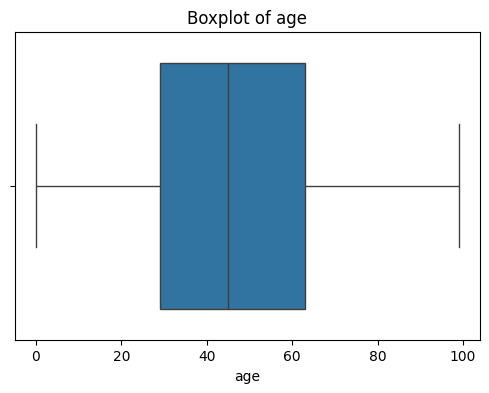

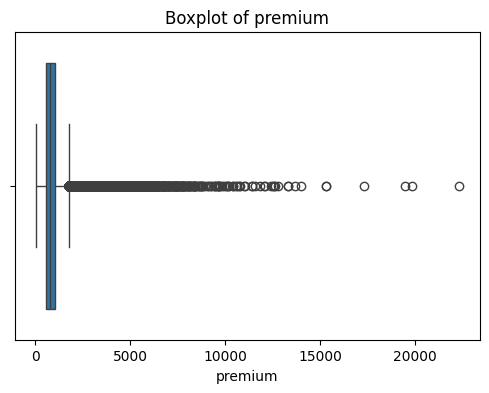

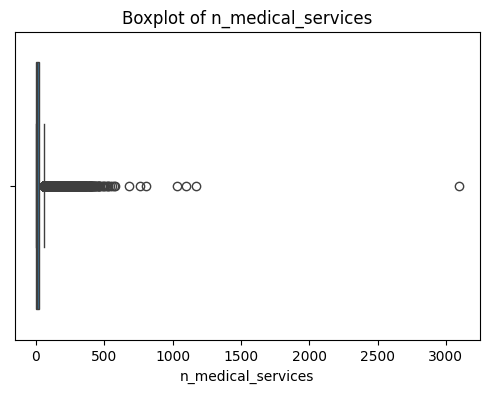

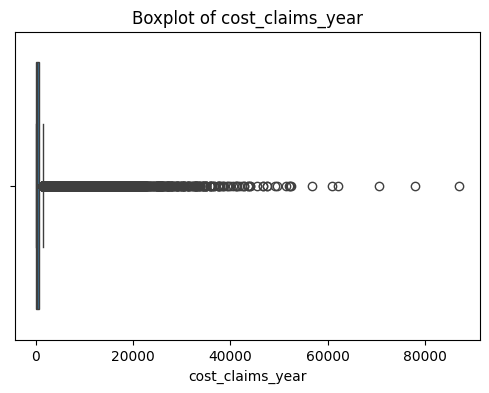

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric features to check for outliers
numeric_cols = ['age', 'premium', 'n_medical_services', 'cost_claims_year']

# Boxplot for each
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


### Outlier Treatment

Replace outliers in numeric columns with the mean value.

In [50]:
# Function to get IQR bounds
def get_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Replace outliers with mean
numeric_cols = ['age', 'premium', 'n_medical_services', 'cost_claims_year']

for col in numeric_cols:
    lower, upper = get_outlier_bounds(df[col])
    mean_val = df[col].mean()
    
    # Replace lower outliers
    df.loc[df[col] < lower, col] = mean_val
    # Replace upper outliers
    df.loc[df[col] > upper, col] = mean_val


### Label Encoding

Convert categorical columns to numeric using LabelEncoder.

In [34]:
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save encoder for potential inverse transform

df.head()


,age,gender,premium,n_medical_services,distribution_channel,type_policy,type_product,cost_claims_year
0,83,1,2923.32,32,0,1,3,8242.62
1,80,0,1930.11,22,0,1,3,344.41
2,80,1,2020.00,24,0,1,2,523.18
3,88,0,1843.25,29,0,1,3,257.55
4,58,1,1316.03,9,0,1,3,420.16


### Correlation Heatmap

Visualize correlations between numerical features.

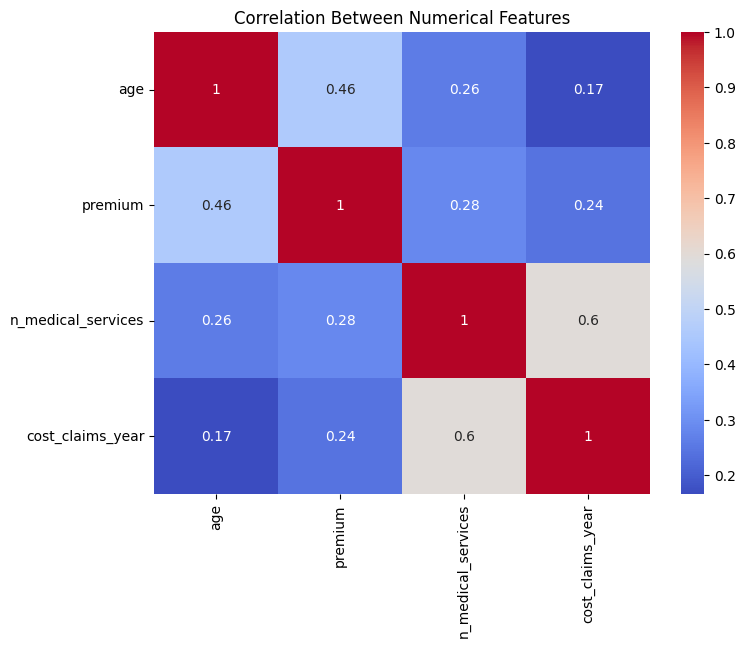

In [35]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Features")
plt.show()

### Distribution Plots

Plot the distribution of each numeric column.

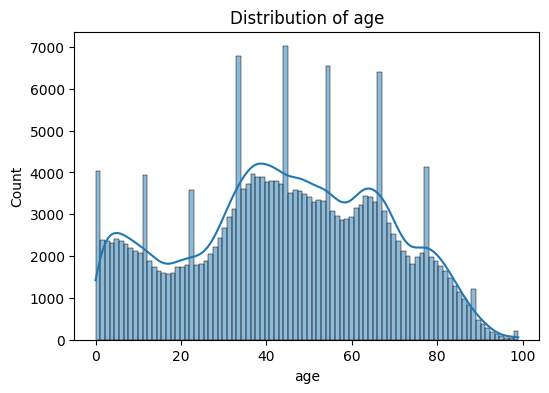

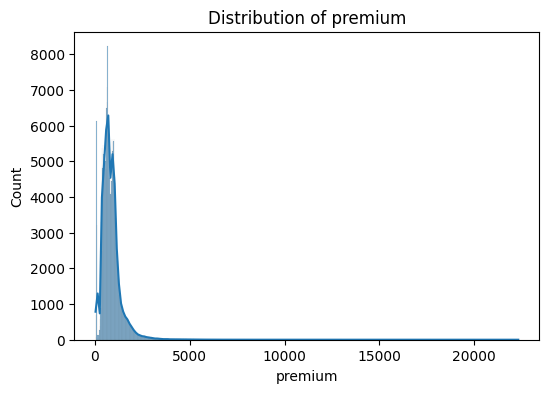

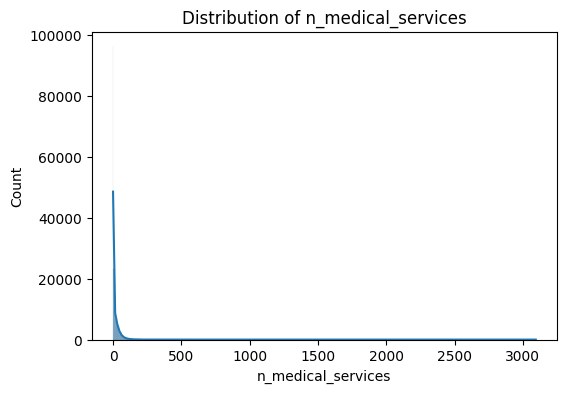

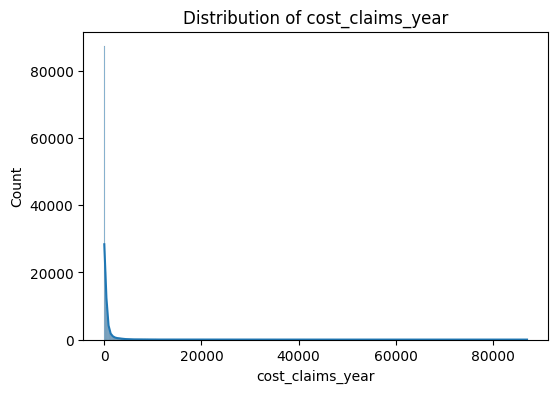

In [36]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

### Feature Engineering

Create new features: age group and premium per service.

In [38]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['Young', 'Adult', 'Senior'])
df['premium_per_service'] = df['premium'] / (df['n_medical_services'] + 1)

### Encode All Categorical Features

Label encode all categorical columns including new features.

In [39]:
encode_cols = ['gender', 'distribution_channel', 'type_policy', 'type_product', 'age_group']
le_dict = {}
for col in encode_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

### Define Features and Target

Separate the features (X) and target variable (y).

In [40]:
X = df.drop('cost_claims_year', axis=1)
y = df['cost_claims_year']

### Feature Scaling

Standardize the feature set.

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Train-Test Split

Split the data into training and testing sets.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Train Linear Regression

Fit a linear regression model and predict on the test set.

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

### Train Random Forest Regressor

Fit a random forest regressor and predict on the test set.

In [44]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### Model Evaluation

Evaluate both models using MAE, RMSE, and R2 metrics.

In [45]:
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f" MAE: {mae:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" R2: {r2:.3f}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")


Linear Regression Results:
 MAE: 139.44
 RMSE: 204.04
 R2: 0.570

Random Forest Results:
 MAE: 114.10
 RMSE: 189.71
 R2: 0.628



### Visualization: Actual vs Predicted

Plot actual vs predicted costs for the Random Forest model.

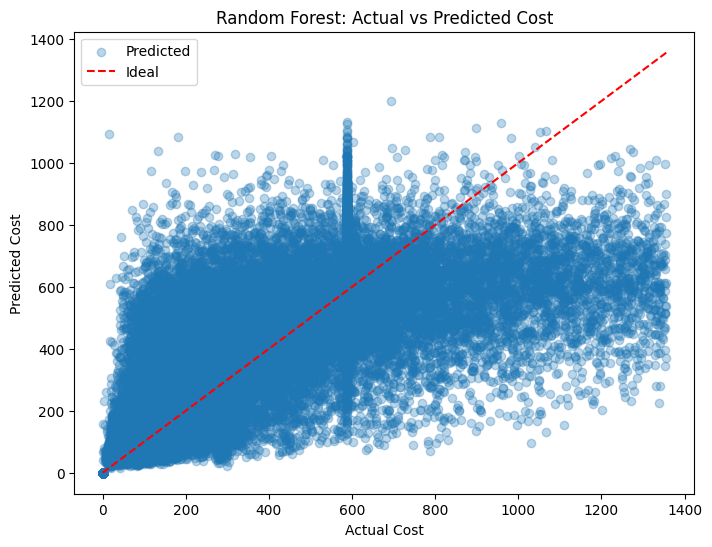

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Random Forest: Actual vs Predicted Cost")
plt.legend()
plt.show()


<!-- (Optional) Add further analysis or conclusion here. -->